In [ ]:
preprocess = True

In [ ]:
from sklearn import datasets
from sklearn.feature_extraction import text

In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.1 MB/s eta 0:00:00


In [ ]:
import sentencepiece as spm
import regex as re

if preprocess:
    s = spm.SentencePieceProcessor(model_file='capstoken.spm')
else:
    s = spm.SentencePieceProcessor(model_file='basetoken.spm')

def replace_caps_fn(m):
    return '<capss>' + m.group(1).lower() + '<capse>' + m.group(3)

def replace_caps(text):
    if text[0] != ' ': text = ' ' + text
    text = re.sub(r'([^\x20\w])([^\s\p{P}\p{Nd}])', r'\1<bksp> \2', text)

    pattern = u'(\x20*\p{Lu}{2,}([\s\p{P}]*\p{Lu}{2,})*)([\s\p{P}])'
    text = re.sub(pattern, replace_caps_fn, text)

    text = re.sub(u'(\x20+[\p{Lu}])', lambda x: '<shift>' + x.group(1).lower(), text)
    return text

def analyzer(text):
    if preprocess:
        text = replace_caps(text)
    return s.encode_as_pieces(text)

In [ ]:
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

newsgroups_train = datasets.fetch_20newsgroups(subset='train',
                                               categories=categories,
                                               remove=('headers', 'footers', 'quotes'))

In [ ]:
data = [(x, y) for (x, y) in zip(newsgroups_train.data, newsgroups_train.target) if len(x) > 100]
xs, ys = [x[0] for x in data], [x[1] for x in data]

In [ ]:
vectorizer = text.TfidfVectorizer(analyzer=analyzer)
vectors = vectorizer.fit_transform(xs)

In [ ]:
from sklearn import metrics
from sklearn.linear_model import RidgeClassifier



newsgroups_test = datasets.fetch_20newsgroups(subset='test',
                                     categories=categories,
                                     remove=('headers', 'footers', 'quotes'))

data_test = [(x, y) for (x, y) in zip(newsgroups_test.data, newsgroups_test.target) if len(x) > 100]
xs_test, ys_test = [x[0] for x in data_test], [x[1] for x in data_test]

vectors_test = vectorizer.transform(xs_test)
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(vectors, ys)
pred = clf.predict(vectors_test)
metrics.f1_score(ys_test, pred, average='macro')

0.7566273846864886

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0    ▁atheist     ▁graphics    ▁space         ▁christian
1   ▁religion        ▁image     ▁nasa               esus
2      ▁islam     ▁computer    ▁orbit        ▁christians
3           \         ▁file   ▁launch               ▁fbi
4         ism      ▁polygon     ▁moon            ▁christ


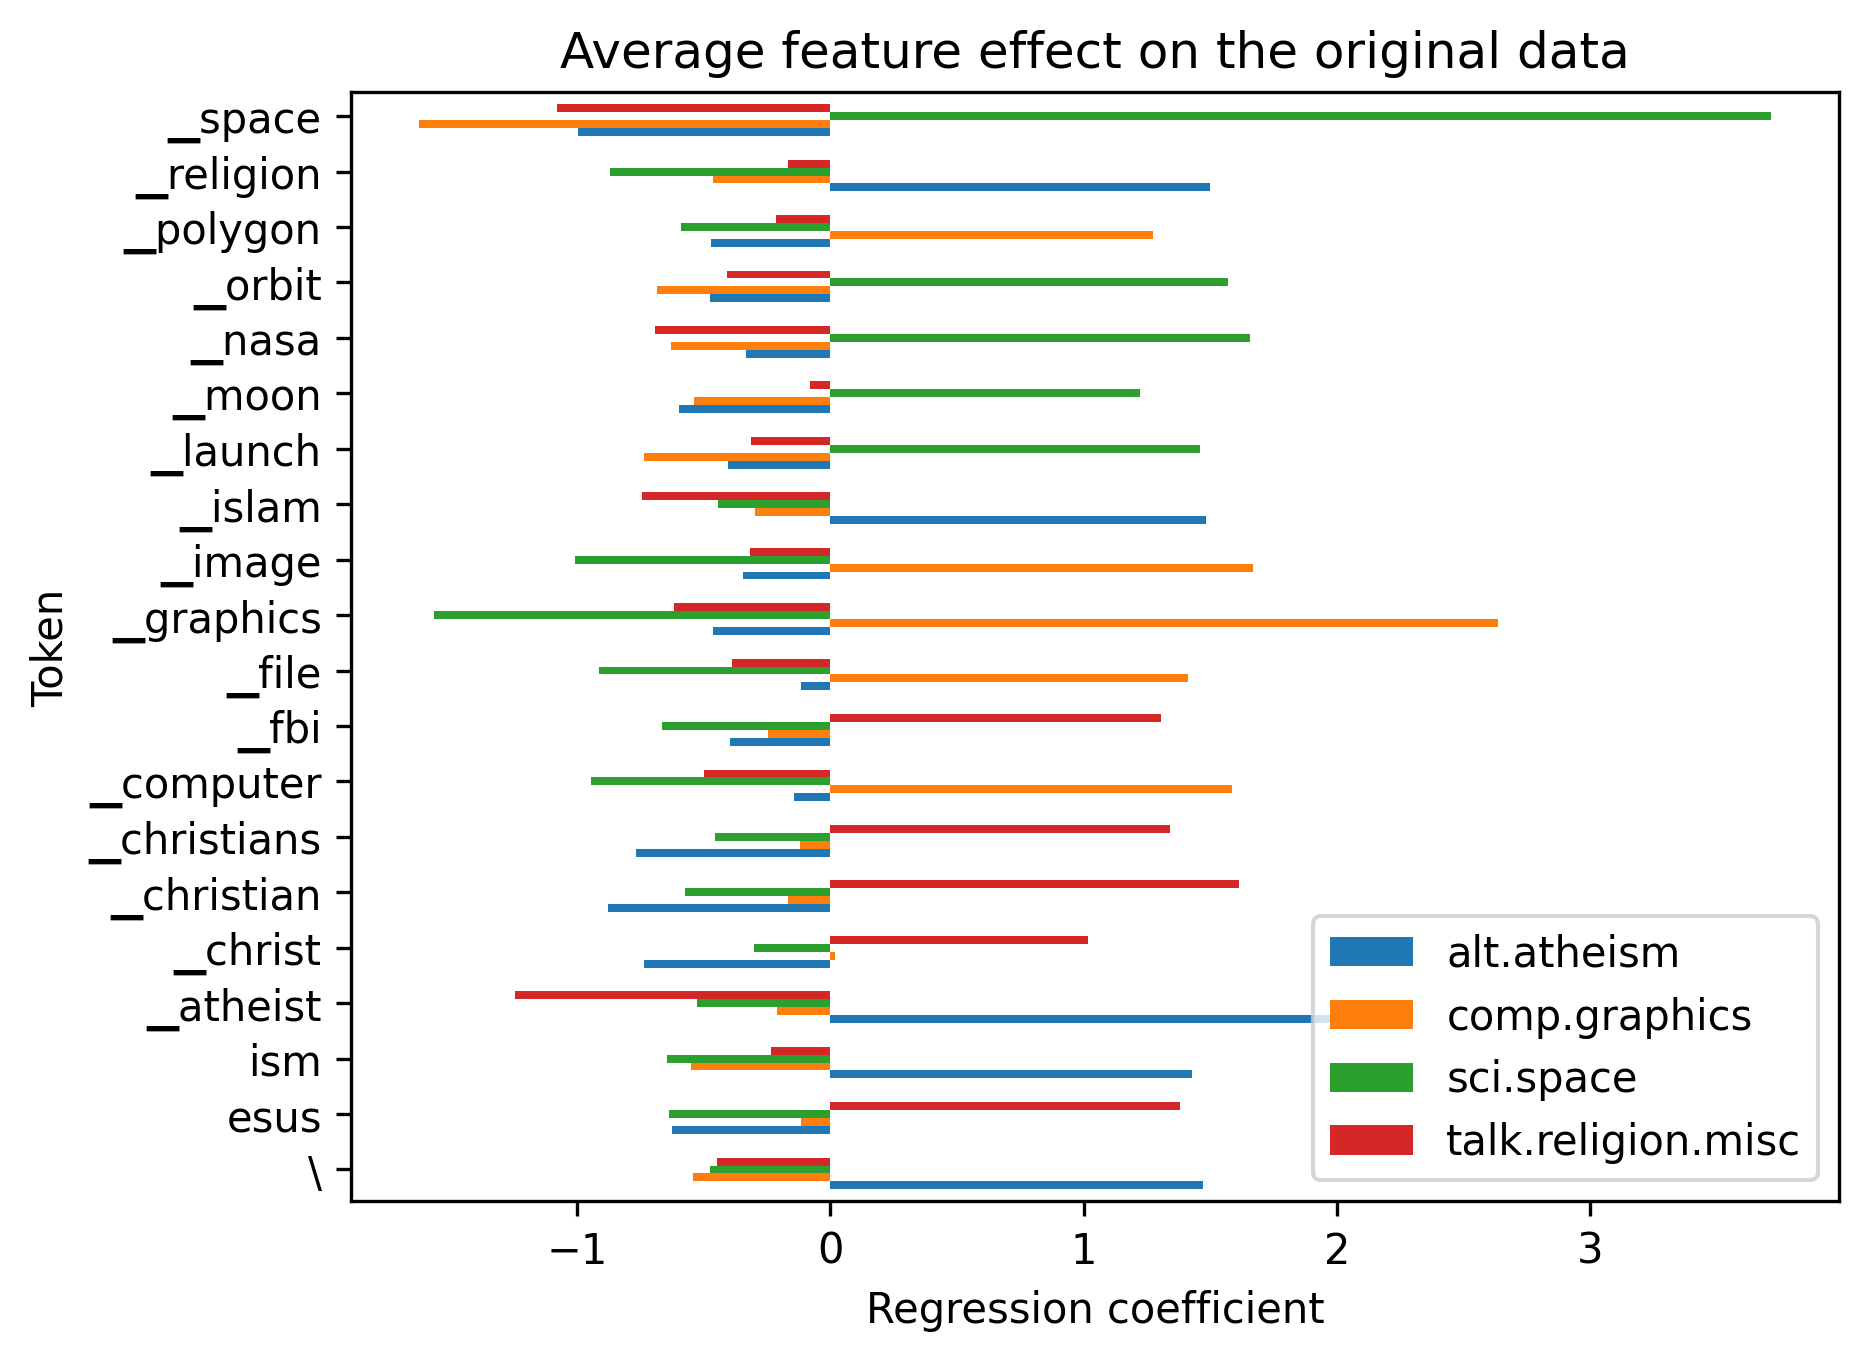

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

target_names = newsgroups_train.target_names
feature_names = vectorizer.get_feature_names_out()

# Plotting code from https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html
def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(dpi=300)
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    ax.set_ylabel('Token')
    ax.set_xlabel('Regression coefficient')

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")

plt.savefig('coeffs.png', bbox_inches='tight', pad_inches = 0, dpi = 300)

##Pathologies

In [ ]:
vocab = set(s.id_to_piece(list(range(2**14))))

In [ ]:
spaced = []
spaced_cap = []
unspaced_cap = []

for token in vocab:
    if token[0] != '▁' and token.lower() == token and len(token) > 1:
        if '▁' + token in vocab:
            spaced += ['▁' + token]
        if '▁' + token[0].upper() + token[1:] in vocab:
            spaced_cap += ['▁' + token[0].upper() + token[1:]]
        if token[0].upper() + token[1:] in vocab and token[0].isalpha():
            unspaced_cap += [token[0].upper() + token[1:]]

In [ ]:
len(spaced), len(spaced_cap), len(unspaced_cap),

(341, 0, 0)

In [ ]:
summed = len(spaced) + len(spaced_cap) + len(unspaced_cap)
summed, summed/2**14

(341, 0.02081298828125)

## Distributions

In [ ]:
import seaborn as sns

In [ ]:
tokenized_xs = [s.id_to_piece(s.encode(replace_caps(x))) for x in xs]

In [ ]:
shifts = [x.count('<shift>') / len(x) for x in tokenized_xs]
caps = [x.count('<capss>') / len(x) for x in tokenized_xs]
bksp = [x.count('<bksp>') / len(x) for x in tokenized_xs]

totals = [(x.count('<bksp>') + x.count('<capss>') + x.count('<shift>') + x.count('<capse>')) for x in tokenized_xs]
total = [x/(len(y)-x)for (x, y) in zip(totals, tokenized_xs)]

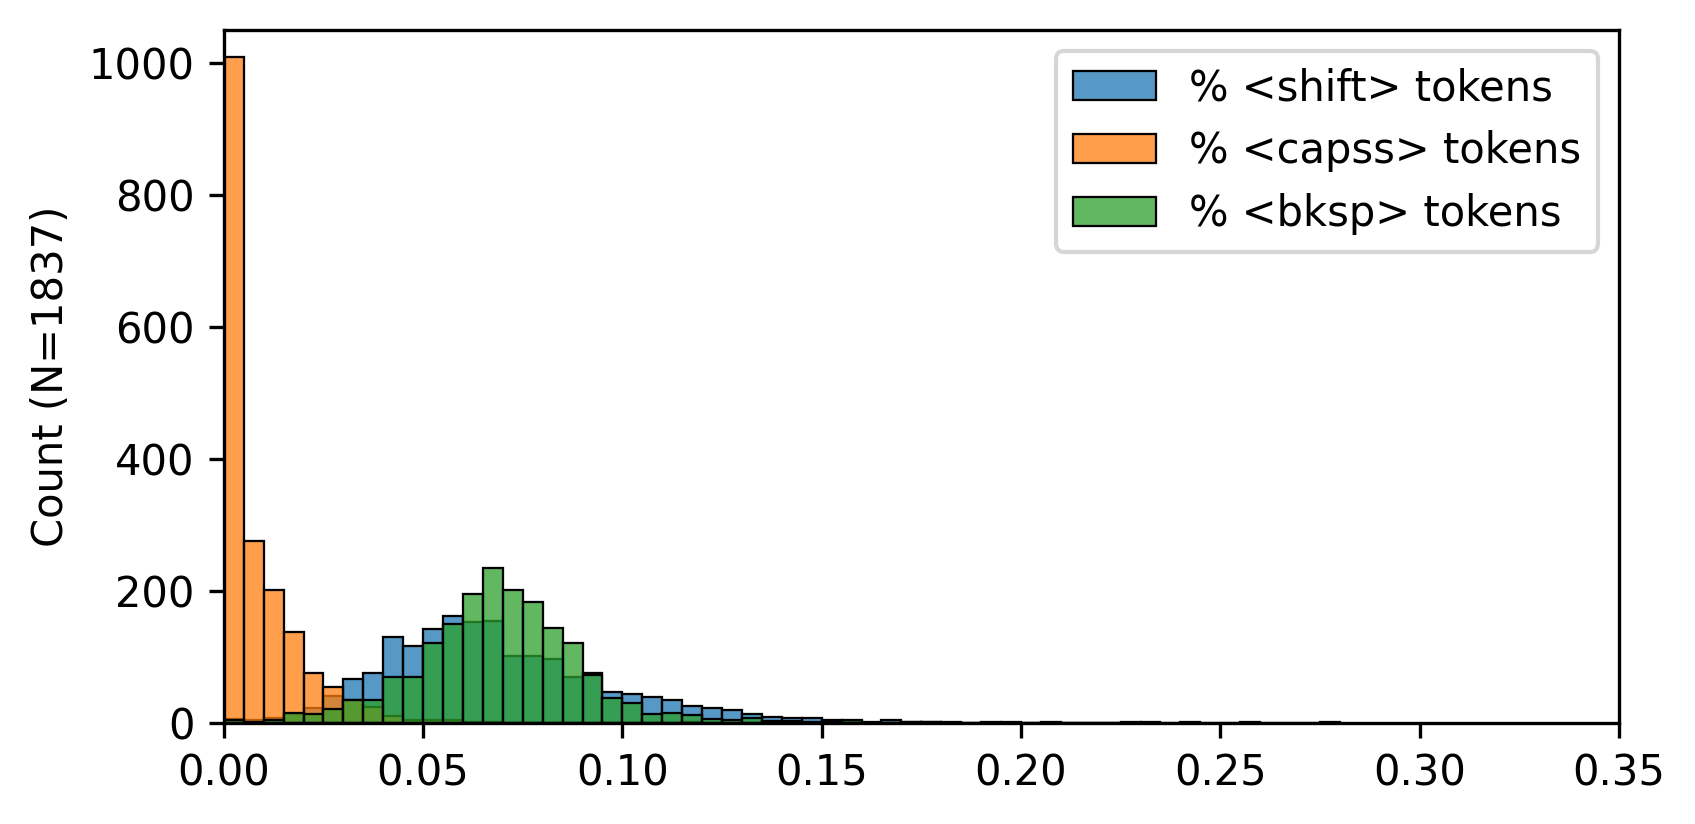

In [ ]:
fig, ax = plt.subplots(dpi=300, nrows=1, figsize=(6, 3))
sns.histplot(ax=ax, x=shifts, binwidth=0.005, label='% <shift> tokens')
sns.histplot(ax=ax, x=caps, binwidth=0.005, label='% <capss> tokens')
sns.histplot(ax=ax, x=bksp, binwidth=0.005, label='% <bksp> tokens')

ax.set_ylabel(f'Count (N={len(shifts)})')
ax.set_xlim(0, 0.35)
ax.set_ylim(0, 1050)
ax.legend()

plt.savefig('dist.png', bbox_inches='tight', pad_inches = 0, dpi = 300)

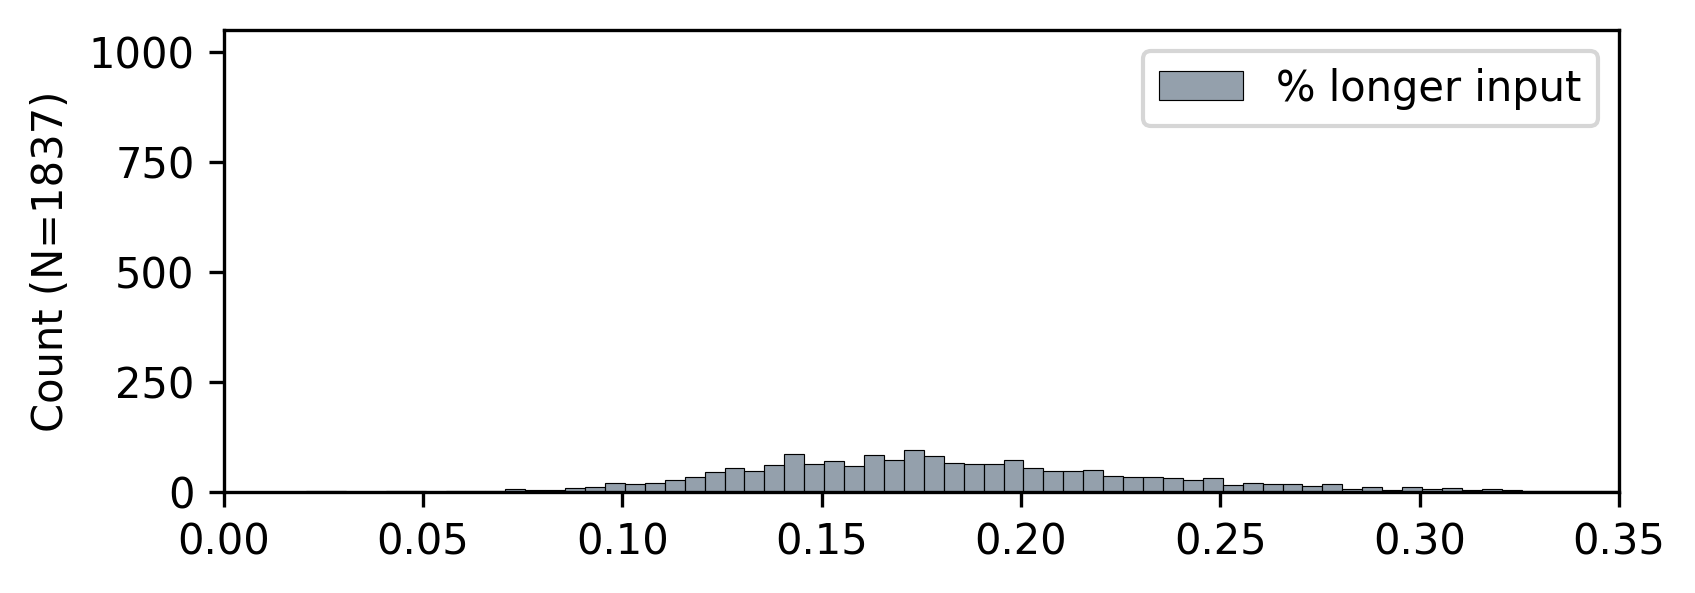

In [ ]:
fig, ax = plt.subplots(dpi=300, nrows=1, figsize=(6, 2))
sns.histplot(ax=ax, x=total, binwidth=0.005, label='% longer input', color='slategray')
ax.set_ylabel(f'Count (N={len(shifts)})')
ax.set_xlim(0, 0.35)
ax.set_ylim(0, 1050)
ax.legend()

plt.savefig('dist2.png', bbox_inches='tight', pad_inches = 0, dpi = 300)

In [ ]:
np.median(shifts), np.median(caps), np.median(bksp), np.median(total)

(0.06451612903225806,
 0.003676470588235294,
 0.06862745098039216,
 0.17684887459807075)